## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [2]:
%matplotlib inline
# %matplotlib ipympl
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')
sys.path.insert(0, home+'/anaconda3')


from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import sis, epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel

import optax
from objax.functional import average_pool_2d

tfd = tfp.distributions

import matplotlib.patches as patches
from matplotlib.path import Path

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate

from ipdb import set_trace
from copy import copy


# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/Users/xiaoshenghuang/miniforge3/lib/python3.9/os.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/model.py


1

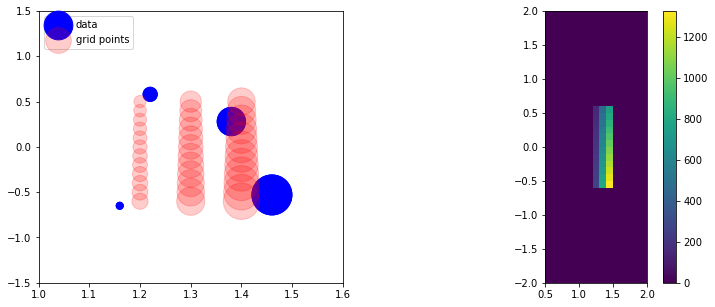

In [4]:
'''
Interpolation example: interpolate grid points onto "data"

Note: origin='lower' for imshow
'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

u = np.array([1.22, 1.38, 1.46, 1.16])
v = np.array([0.58, 0.28, -0.53, -0.65])
uvpix = np.array([200, 800, 1600, 50])
ax1.scatter(u, v, s=uvpix, c='b', label='data')

h = interpolate.interp2d(u, v, uvpix, fill_value=0.0)

ulo, uhi = 0.5, 2
vlo, vhi = -2, 2
u1 = np.arange(ulo, uhi, 0.1)
v1 = np.arange(vlo, vhi, 0.1)

extent = [ulo, uhi, vlo, vhi]

uu, vv = np.meshgrid(u1, v1)

ax1.scatter(u, v, s=uvpix, c='b')
ax1.set_xlim(1.0, 1.6)
ax1.set_ylim(-1.5, 1.5)
newpix1 = h(u1, v1)

u1.shape, v1.shape, newpix1.shape
ax1.scatter(uu.flatten(), vv.flatten(), s=newpix1.flatten(), c='r', alpha=0.2, label='grid points')
ax1.legend(loc='upper left')

im = ax2.imshow(newpix1, origin='lower', extent=extent)
fig.colorbar(im)

In [218]:
# How to average pool
# One has to be very careful with shape!!!
a = jnp.array(np.random.random((1, 1, 16, 16)))
b = average_pool_2d(a, size=(2, 2)) 
c = average_pool_2d(a, size=2)
a.shape, b.shape, c.shape

((1, 1, 16, 16), (1, 1, 8, 8), (1, 1, 8, 8))

In [3]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)


# more readable form 
def extract_params(best_params):

    # mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    # shear_params = ['gamma1', 'gamma2']
    mass_params = ['theta_E', 'center_x', 'center_y']

    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')


center: 30
theta_E_pix: 13.846153846153847
src center in pix (x, y): 34.61538461538461 30.0
Ie, observed_img.max, observed_img.min 100 71.439865 -7.325155e-06
theta_E location in pixels: 43.0
edge, corner in arcsec: 2.015 2.849640328181787
beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}


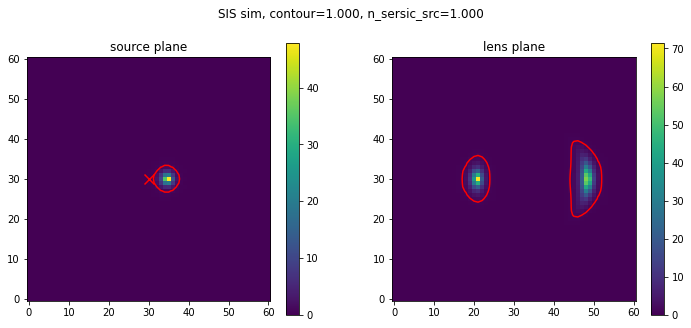

In [177]:
delta_pix = 0.065
num_pix = 61
ctr = num_pix//2
supersample = 1
# theta_E = 2.1 #* (num_pix/101)
theta_E = 0.9 #* (num_pix/101)
Ie_src = 100
n_sersic_src = 1.0

print('center:', ctr)

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
phys_model = PhysicalModel([sis.SIS()], [sersic.Sersic(use_lstsq=False)], [sersic.Sersic(use_lstsq=False)])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

# background_rms, exp_time = 0.2, 100
background_rms, exp_time = 2e-6, 1e6

# clearly problematic case: theta_E = 1.1, delta_pix = 0.065, num_pix = 61

theta_E_pix = theta_E / delta_pix
print('theta_E_pix:', theta_E_pix)

lens_ctrx, lens_ctry = 0.0, 0.0

# src_ctrx, src_ctry = 0.5, 0.0  #0.5, 0.
src_ctrx, src_ctry = 0.3, 0.0  #0.5, 0.

src_ctrx_pix, src_ctry_pix = ctr + src_ctrx / delta_pix, ctr + src_ctry / delta_pix  #0.5, 0.
print('src center in pix (x, y):', src_ctrx_pix, src_ctry_pix)

lens_params = [{'theta_E': theta_E, 'center_x': lens_ctrx, 'center_y': lens_ctry}]
lens_light = [{'R_sersic': 0.8, 'n_sersic': 4.0, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 1e-3}]
source_light = [{'R_sersic': 0.05, 'n_sersic': n_sersic_src, 'center_x': src_ctrx, 'center_y': src_ctry, 'Ie': Ie_src}]
# source_light = [{'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': 0.0, 'e2': 0., 'center_x': src_ctrx, 'center_y': src_ctry, 'Ie': Ie_src}]


print('Ie, observed_img.max, observed_img.min', Ie_src, observed_img.max(), observed_img.min())
print('theta_E location in pixels:', theta_E//delta_pix + ctr)
print('edge, corner in arcsec:', (num_pix-ctr)*delta_pix, (num_pix-ctr)*delta_pix*np.sqrt(2))


# no_deflection=True causes an error
src_truth = [lens_params, lens_light, source_light]
src_truth[0][0]['theta_E'] = 1e-10
noiseless_src = lens_sim.simulate(src_truth)

truth = [lens_params, lens_light, source_light]
src_truth[0][0]['theta_E'] = theta_E

noiseless_img = lens_sim.simulate(truth)
observed_img = noiseless_img + \
                np.random.normal(0, background_rms, noiseless_img.shape) + \
                np.random.poisson(noiseless_img/exp_time, noiseless_img.shape)

# observed_img = np.load('./src/gigalens/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)


X, Y = np.meshgrid(np.linspace(0, num_pix - 1, num_pix), np.linspace(0, num_pix - 1, num_pix))

def plot_contour(ax, img, X, Y, con_levels=[0.04]):
    con_levels = con_levels

    cs = ax.contour(X, Y, img, con_levels, colors='r')

    return cs

con_levels = [1.0]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

srcax = ax1.imshow(noiseless_src, origin='lower')
fig.colorbar(srcax, ax=ax1)
_ = plot_contour(ax1, noiseless_src, X, Y, con_levels=con_levels)
ax1.scatter(ctr, ctr, marker='x', s=100, color='r')
ax1.set_title('source plane')


imgax = ax2.imshow(observed_img, origin='lower') #, vmin=0, vmax=10)
cs = plot_contour(ax2, observed_img, X, Y, con_levels=con_levels)
fig.colorbar(imgax, ax=ax2)
ax2.set_title('lens plane')

plt.suptitle('SIS sim, contour={:.3f}, n_sersic_src={:.3f}'.format(con_levels[0], n_sersic_src))
plt.show()



shapes of beta_x, beta_y: (61, 61, 1) (61, 61, 1)
(1, 1, 61, 61) (1, 1, 61, 61)
down sampled alpha shapes: (1, 1, 61, 61) (1, 1, 61, 61)
(61, 61)
points shape (3721, 2)
(3721,)
(1, 1, 61, 61) (61, 61)


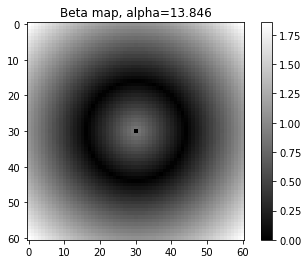

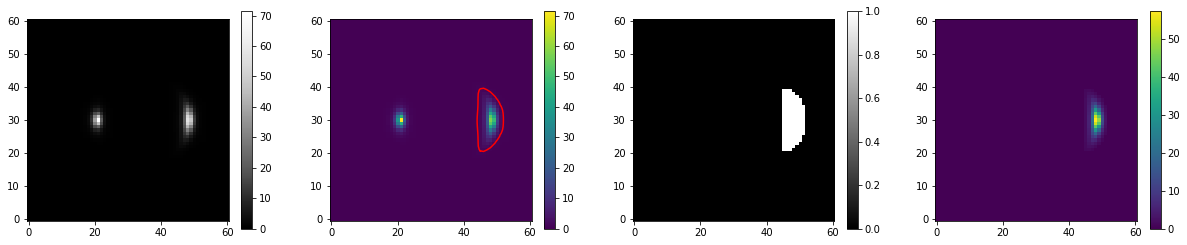

In [165]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y:', beta_x.shape, beta_y.shape)
fig, ax = plt.subplots(1, 1)
beta = np.sqrt(beta_x ** 2 + beta_y ** 2)
betaim = plt.imshow(beta, interpolation=None, cmap='gray')
fig.colorbar(betaim, ax=ax)
plt.title('Beta map, alpha={:.3f}'.format(theta_E_pix))

## One has to be very careful with shape!!!
from objax.functional import average_pool_2d
f_xi = jnp.transpose(f_xi, (2, 0, 1))[jnp.newaxis, ...] 
f_yi = jnp.transpose(f_yi, (2, 0, 1))[jnp.newaxis, ...] 

print(f_xi.shape, f_yi.shape) #, f_yi_newaxis.shape)

f_xi_downsamp = average_pool_2d(f_xi, size=lens_sim.supersample, padding="SAME") 
f_yi_downsamp = average_pool_2d(f_yi, size=lens_sim.supersample, padding="SAME") 

print('down sampled alpha shapes:', f_xi_downsamp.shape, f_yi_downsamp.shape)

# ----------------------------------------------------------------------------------------------------------------
n_subfigs = 4
axes = []*n_subfigs
fig_h = 4

# To get the BIG arc
fig, axes = plt.subplots(1, n_subfigs, figsize=(fig_h*n_subfigs*1.3, fig_h))
axes[0].set_aspect('equal')

obsim = axes[0].imshow(observed_img, cmap=plt.cm.Greys_r, origin='lower')
plt.colorbar(obsim, ax=axes[0])

idx_cont = [0, 1]
verts = [np.array([[], []]).T, np.array([[], []]).T] 

for i, idx in enumerate(idx_cont):
    verts[i] = np.concatenate((verts[i], cs.collections[0].get_paths()[idx].vertices), axis=0)

xc, yc = verts[0][:, 0], verts[0][:, 1]
axes[1].plot(xc, yc, color='r')

obsim = axes[1].imshow(observed_img, origin='lower')
plt.colorbar(obsim, ax=axes[1])

print(X.shape)
path = Path(verts[0])
points = np.vstack((X.flatten(), Y.flatten())).T

print('points shape', points.shape)

counterarcmask = path.contains_points(points)
print(counterarcmask.shape)

counterarcmask = counterarcmask.reshape((num_pix, num_pix))
maskim = axes[2].imshow(counterarcmask, cmap='gray', origin='lower')
plt.colorbar(maskim, ax=axes[2])

counterarc = observed_img * counterarcmask
con_arcim = axes[3].imshow(counterarc, origin='lower')
plt.colorbar(con_arcim, ax=axes[3])

print(f_xi_downsamp.shape, counterarcmask.shape)

f_xi_ca = f_xi_downsamp * counterarcmask
f_yi_ca = f_yi_downsamp * counterarcmask


shapes of beta_x, beta_y: (61, 61, 1) (61, 61, 1)
(1, 1, 61, 61) (1, 1, 61, 61)
down sampled alpha shapes: (1, 1, 61, 61) (1, 1, 61, 61)
(61, 61)
(3721,)


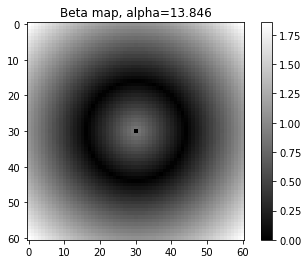

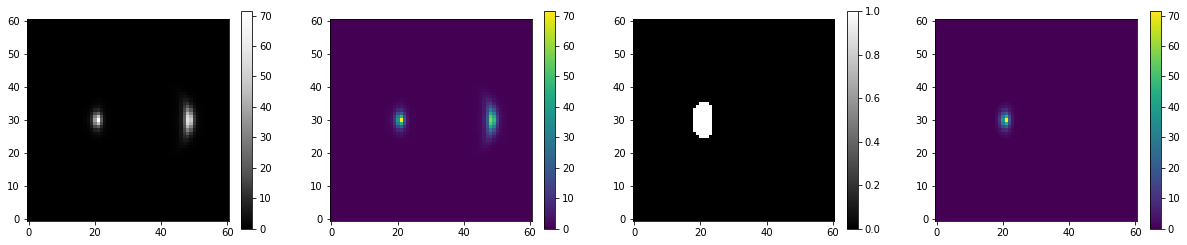

In [ ]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y:', beta_x.shape, beta_y.shape)
fig, ax = plt.subplots(1, 1)
beta = np.sqrt(beta_x ** 2 + beta_y ** 2)
betaim = plt.imshow(beta, interpolation=None, cmap='gray')
fig.colorbar(betaim, ax=ax)
plt.title('Beta map, alpha={:.3f}'.format(theta_E_pix))

## One has to be very careful with shape!!!
from objax.functional import average_pool_2d
f_xi = jnp.transpose(f_xi, (2, 0, 1))[jnp.newaxis, ...] 
f_yi = jnp.transpose(f_yi, (2, 0, 1))[jnp.newaxis, ...] 

print(f_xi.shape, f_yi.shape) #, f_yi_newaxis.shape)

f_xi_downsamp = average_pool_2d(f_xi, size=lens_sim.supersample, padding="SAME") 
f_yi_downsamp = average_pool_2d(f_yi, size=lens_sim.supersample, padding="SAME") 

print('down sampled alpha shapes:', f_xi_downsamp.shape, f_yi_downsamp.shape)

# ----------------------------------------------------------------------------------------------------------------
n_subfigs = 4
axes = []*n_subfigs
fig_h = 4

# To get the BIG arc
fig, axes = plt.subplots(1, n_subfigs, figsize=(fig_h*n_subfigs*1.3, fig_h))
axes[0].set_aspect('equal')

obsim = axes[0].imshow(observed_img, cmap=plt.cm.Greys_r, origin='lower')
plt.colorbar(obsim, ax=axes[0])

idx_cont = [0, 1]
verts = [np.array([[], []]).T, np.array([[], []]).T] 

counterarcmask = []

for i, idx in enumerate(idx_cont):
    verts[i] = np.concatenate((verts[i], cs.collections[0].get_paths()[idx].vertices), axis=0)
    xc, yc = verts[i][:, 0], verts[i][:, 1]

    path = Path(verts[i])
    points = np.vstack((X.flatten(), Y.flatten())).T
    counterarcmask.append(path.contains_points(points))


axes[1].plot(xc[i], yc[i], color='r')

obsim = axes[1].imshow(observed_img, origin='lower')
plt.colorbar(obsim, ax=axes[1])

print(X.shape)
# path = Path(verts[0])
# points = np.vstack((X.flatten(), Y.flatten())).T

# print('points shape', points.shape)

# counterarcmask = path.contains_points(points)
print(counterarcmask[i].shape)

counterarcmask[i] = counterarcmask[i].reshape((num_pix, num_pix))
maskim = axes[2].imshow(counterarcmask[i], cmap='gray', origin='lower')
plt.colorbar(maskim, ax=axes[2])

counterarc = observed_img * counterarcmask[i]
con_arcim = axes[3].imshow(counterarc, origin='lower')
plt.colorbar(con_arcim, ax=axes[3])

# print(f_xi_downsamp.shape, counterarcmask.shape)

# f_xi_ca = f_xi_downsamp * counterarcmask
# f_yi_ca = f_yi_downsamp * counterarcmask


shapes of beta_x, beta_y, f_xi, f_yi: (61, 61, 1) (61, 61, 1) (61, 61, 1) (61, 61, 1)
(61, 61, 1)
max img: 2.7577164
(61, 61, 1) (61, 61, 1)
down sampled alpha shapes: (1, 1, 61, 61) (1, 1, 61, 61)
beta shapes: (61, 61, 1) (61, 61, 1)


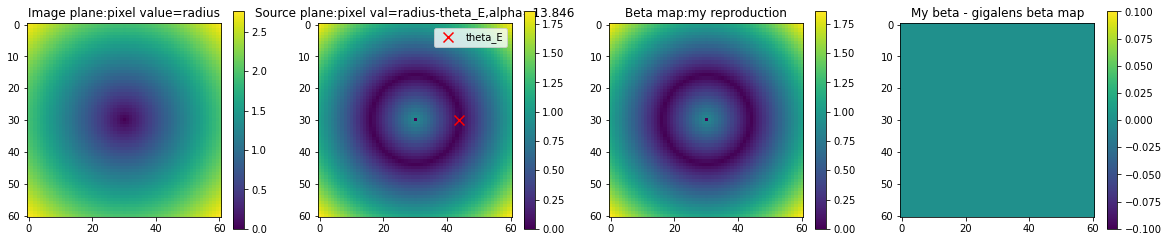

In [148]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y, f_xi, f_yi:', beta_x.shape, beta_y.shape, f_xi.shape, f_yi.shape)
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# ************ image plane from gigalens ********************
imgX = lens_sim.img_X
imgY = lens_sim.img_Y
print(imgX.shape)

img = np.sqrt(imgX ** 2 + imgY ** 2)
print('max img:', img.max())

im = axes[0].imshow(img)
axes[0].set_title('Image plane:pixel value=radius')
fig.colorbar(im, ax=axes[0])

# ************ source plane from gigalens ********************
beta = np.sqrt(beta_x ** 2 + beta_y ** 2)
betaim = axes[1].imshow(beta)
axes[1].scatter(ctr+theta_E_pix, ctr, marker='x', color='r', s=100, label='theta_E')
axes[1].legend()
fig.colorbar(betaim, ax=axes[1])
axes[1].set_title('Source plane:pixel val=radius-theta_E,alpha={:.3f}'.format(theta_E_pix))

## w/ jnp average_pool_2d, one has to be very careful with shape!!!
print(f_xi.shape, f_yi.shape) #, f_yi_newaxis.shape)

f_xi_downsamp = average_pool_2d(jnp.transpose(f_xi, (2, 0, 1))[jnp.newaxis, ...], size=lens_sim.supersample, padding="SAME") 
f_yi_downsamp = average_pool_2d(jnp.transpose(f_yi, (2, 0, 1))[jnp.newaxis, ...], size=lens_sim.supersample, padding="SAME") 

print('down sampled alpha shapes:', f_xi_downsamp.shape, f_yi_downsamp.shape)
print('beta shapes:', beta_x.shape, beta_y.shape)


# ************ Calculating beta myself ***********************
b_x, b_y = imgX - f_xi, imgY - f_yi
b = np.sqrt(b_x**2 + b_y**2)
bim = axes[2].imshow(b)
axes[2].set_title('Beta map:my reproduction')
fig.colorbar(bim, ax=axes[2])

bres = axes[3].imshow(b - beta)
axes[3].set_title('My beta - gigalens beta map')

fig.colorbar(bres, ax=axes[3])

plt.show()

13.846155 13.846155


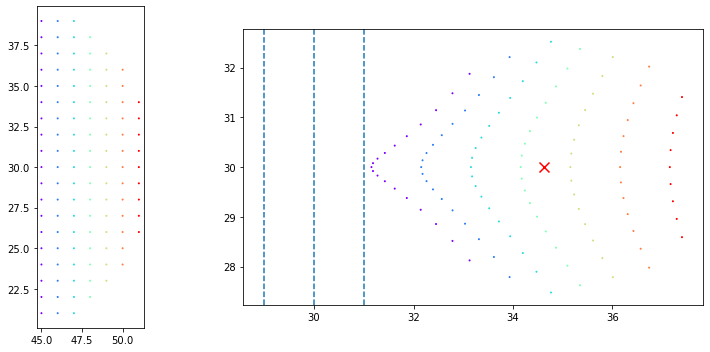

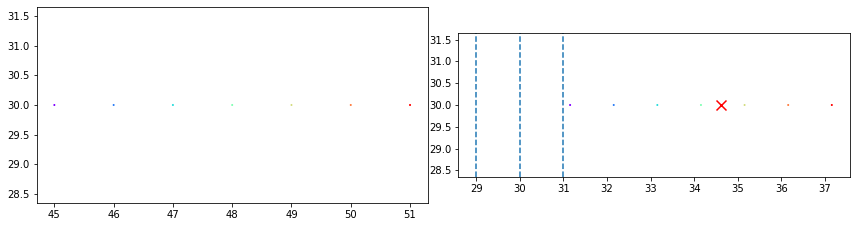

In [149]:
'''
Now delens:
'''
alfx_pix = np.squeeze(f_xi_downsamp) / delta_pix
alfy_pix = np.squeeze(f_yi_downsamp) / delta_pix

arcxy = np.where(counterarcmask > 0)

arcx = arcxy[1]
arcy = arcxy[0]

srcy = arcy - alfy_pix[arcxy]
srcx = arcx - alfx_pix[arcxy]

hiy = np.percentile(arcy, 90)
idx = arcy >= hiy

arcx_hiy = arcx[idx]
arcy_hiy = arcy[idx]

srcx_hiy = srcy[idx]
srcy_hiy = srcy[idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(arcx, arcy, c=arcx, cmap='rainbow', s=1)

ax1.set_aspect('equal')

nub_ln1 = ctr
nub_ln2 = ctr - 1.
nub_ln3 = ctr + 1.


ax2.scatter(srcx, srcy, c=arcx, cmap='rainbow', s=1)
ax2.axvline(nub_ln1, ls='--')
ax2.axvline(nub_ln2, ls='--')
ax2.axvline(nub_ln3, ls='--')


# ax2.plot(srcx, srcy, '.', ms=1)
# ax2.plot(srcx_hiy, srcy_hiy, 'r.')

ax2.set_aspect('equal')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=100, marker='x', color='r')
plt.tight_layout()
print(alfx_pix.max(), alfy_pix.max())

# zoom on the flat part

arc_loc = ctr + theta_E_pix
arc_w = 40
arc_h = 40

# idx1 = (arcx > arc_loc - arc_w/1) * (arcy > ctr - arc_h/0.6) * (arcy < ctr + arc_h/0.6)
# idx2 =  (arcy > ctr + arc_h/4) + (arcy < ctr - arc_h/4)
# idx3 =  (arcy < ctr + arc_h/8) * (arcy > ctr - arc_h/8)

idx4 = arcy == ctr

# idx = idx1 * idx2
idx = idx4

flat_arcx = arcx[idx]
flat_arcy = arcy[idx]

flat_srcx = srcx[idx]
flat_srcy = srcy[idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(flat_arcx, flat_arcy, c=flat_arcx, cmap='rainbow', s=1)
# ax1.plot(arcx, arcy, '.')
# ax1.plot(arcx_hiy, arcy_hiy, 'r.')

ax1.set_aspect('equal')

ax2.scatter(flat_srcx, flat_srcy, c=flat_arcx, cmap='rainbow', s=1)

ax2.set_aspect('equal')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=100, marker='x', color='r')
ax2.axvline(nub_ln1, ls='--')
ax2.axvline(nub_ln2, ls='--')
ax2.axvline(nub_ln3, ls='--')


plt.tight_layout()


(24.615384615384613, 44.61538461538461, 20.0, 40.0)

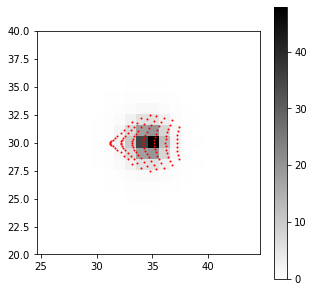

In [150]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
sax = ax.imshow(noiseless_src, cmap='gray_r')
ax.scatter(srcx, srcy, color='red', s=1)
f.colorbar(sax, ax=ax)

wid = 10
plt.axis([ctr + src_ctrx/delta_pix - wid, ctr + src_ctrx/delta_pix + wid, ctr-wid, ctr+wid])

30.0 (3721, 2)


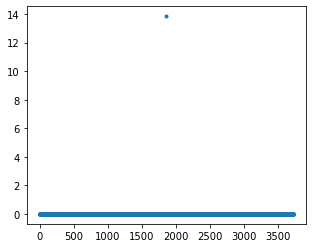

[-39.79071  -39.955223 -40.122303 -40.291763 -40.463387 -40.63691
 -40.812027 -40.988396 -41.165607 -41.34321 ] [41.34321  41.165607 40.988396 40.812027 40.63691  40.463387 40.291763
 40.122303 39.955223 39.79071 ]
[-39.79071  -38.623383 -37.447483 -36.26259  -35.068268 -33.86409
 -32.649624 -31.424437 -30.188112 -28.940247] [28.940247 30.188112 31.424437 32.649624 33.86409  35.068268 36.26259
 37.447483 38.623383 39.79071 ]


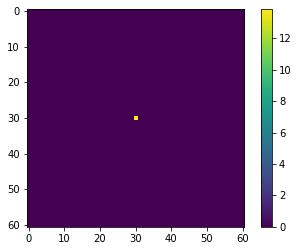

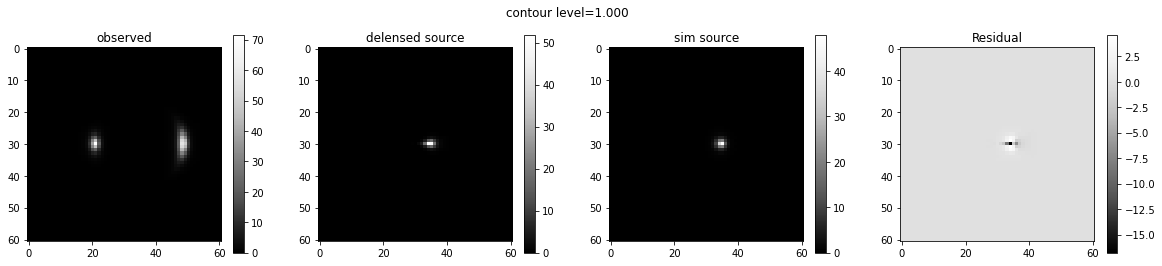

In [151]:
'''
Breakout Solution: Fisheye distortion

One can shift the "center" to have different parts of the face be at 
the center of the final image.

One can obviously shift the different parameters in the r 
equation to enhance or reduce the effect.


'''

from skimage import transform, data, io
import matplotlib.image as mpimg
import matplotlib.cm as cm

def delensing(xy):
    center = np.sqrt(xy.shape[0])//2
    print(center, xy.shape)
    xc, yc = (xy - center).T

    r = np.sqrt(xc**2 + yc**2)
    theta = np.arctan2(yc, xc)
    
    alf_xx, alf_yy = theta_E_pix*np.cos(theta), theta_E_pix*np.sin(theta)

    # xnew = xc + alf_x
    # ynew = yc + alf_y
    
    # ---------> note how the x and y need to swapped to get this right
    
    xnew = xc + f_yi_flat
    ynew = yc + f_xi_flat
    
    plt.figure(figsize=(5, 4))
    plt.plot(alf_xx - f_yi_flat, '.')
    plt.show()
    
    plt.figure()
    plt.imshow(alf_xx.reshape(num_pix, -1) - f_yi_flat.reshape(num_pix, -1))
    plt.colorbar()
    
    print(xnew[:10], xnew[-10:])
    print(ynew[:10], ynew[-10:])

    return np.column_stack((xnew, ynew)) + center

observed_im = np.squeeze(observed_img)

delens = transform.warp(observed_im, delensing)

f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 4)) # subplot_kw=dict(xticks=[], yticks=[]))
obsim = ax0.imshow(observed_im, cmap=cm.Greys_r)
ax0.set_title('observed')
f.colorbar(obsim, ax=ax0)
delensim = ax1.imshow(delens, cmap=cm.Greys_r)
ax1.set_title('delensed source')
f.colorbar(delensim, ax=ax1)

srcim = ax2.imshow(noiseless_src, cmap=cm.Greys_r)
ax2.set_title('sim source')
f.colorbar(srcim, ax=ax2)


res = np.array(noiseless_src - delens)
# normres = res/np.array(observed_im)
resim = ax3.imshow(res, cmap=cm.Greys_r)
f.colorbar(resim, ax=ax3)
ax3.set_title('Residual')

plt.suptitle('contour level={:.3f}'.format(con_levels[0]))

# normresim = ax3.imshow(normres) #, vmin=0, vmax=1.0)
# f.colorbar(normresim, ax=ax3)
# ax3.set_title('Norm residual')

plt.show()
